#   LangGraph 활용 - 상태 그래프 구현

---

## 환경 설정 및 준비

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import os
from glob import glob

from pprint import pprint
import json

`(3) Langsmith tracing 설정`

In [3]:
# Langsmith tracing 여부를 확인 (true: langsmith 추척 활성화, false: langsmith 추척 비활성화)
import os
print(os.getenv('LANGSMITH_TRACING'))

false


---

## **StateGraph**

- **StateGraph**는 상태 기반의 그래프 구조를 사용하여 **대화 흐름을 체계적으로 관리**

- 예제: **기본 챗봇 시스템**
    - 챗봇은 **StateGraph**를 통해 상태 기반 구조로 구현 (**노드**와 **엣지**로 구성)
    - 챗봇의 실행 흐름은 **START**에서 시작하여 **END**로 종료되며, 엣지를 통해 노드 간 전환을 처리

`(1) 상태(State)`

- **상태(State)** 는 그래프에서 처리하는 **데이터의 기본 구조**를 정의

- 각 상태는 다른 상태에 의해 **override(덮어쓰기)** 될 수 있어 데이터를 유연하게 관리할 수 있음 

- 상태 관리를 통해 **체계적인 데이터 처리**와 **흐름 제어**가 가능

In [4]:
from typing import TypedDict

# 상태 정의
class State(TypedDict):
    original_text: str   # 원본 텍스트
    summary: str         # 요약본
    final_summary: str   # 최종 요약본

- TypedDict를 사용하여 그래프의 상태를 정의
- 상태는 그래프 실행 중에 노드 간에 공유되는 데이터

`(2) 노드(Node)`

- **노드(Node)** 는 그래프 구조의 기본 구성 요소

- 노드는 **독립적인 작업 단위**로 특정 함수를 실행

- 각 노드는 다른 노드와 연결되어 **데이터 흐름**을 형성

- 상태를 입력으로 받아 처리하고 업데이트된 상태를 반환 

In [5]:
from langchain_openai import ChatOpenAI

# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# 요약 생성 노드
def generate_summary(state: State):
    """원본 텍스트를 요약하는 노드"""
    prompt = f"""다음 텍스트를 핵심 내용 중심으로 간단히 요약해주세요:

    [텍스트]
    {state['original_text']}

    [요약]
    """
    response = llm.invoke(prompt)
    
    return {"summary": response.content}

`(3) 그래프(Graph) 구성`

- **그래프(Graph)** 는 여러 노드들을 **엣지(Edge)**로 연결한 집합체

- 각 노드 간의 **연결 관계**가 전체 데이터 흐름을 결정

- 그래프는 빌드가 완료된 후 **실행 가능한 상태**가 됨 

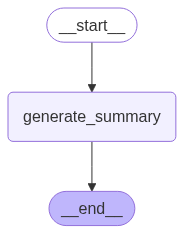

In [6]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# StateGraph 객체 생성 (Workflow)
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("generate_summary", generate_summary)

# 시작(START)과 끝(END) 엣지 추가 : 시작 -> generate_summary -> 끝
workflow.add_edge(START, "generate_summary")
workflow.add_edge("generate_summary", END)

# 그래프 컴파일
graph = workflow.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

`(4) invoke 실행`

- **invoke** 방식은 그래프의 가장 **기본적인 실행 방법**으로, 단순하고 직관적인 처리를 제공

- 실행 결과는 모든 처리가 완료된 후 **최종 결과값**만 반환

- 전체 처리 과정이 완료될 때까지 **동기적으로 대기**하므로, 중간 상태를 확인할 수 없음 

- 간단한 처리나 최종 결과만 필요한 경우에 적합한 실행 방식

In [7]:
# 사용 예시
text = """
인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력, 
자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다. 
최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.
"""

initial_state = {
    "original_text": text,
}

final_state = graph.invoke(initial_state)

for key, value in final_state.items():
    print(f"{key}")
    print("-" * 50)
    pprint(f"{value}")
    print("=" * 100)

original_text
--------------------------------------------------
('\n'
 '인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력, \n'
 '자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다. \n'
 '최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.\n')
summary
--------------------------------------------------
('인공지능(AI)은 인간의 학습, 추론, 지각, 자연어 이해 능력을 컴퓨터로 구현한 기술로, 최근 기계학습과 딥러닝의 발전으로 다양한 '
 '분야에서 활용되고 있다.')


`(5) 조건부 엣지(Edge)`

- **엣지**는 노드 간의 **연결 경로**를 정의하며, 챗봇의 대화 흐름을 구성하는 핵심 요소

- **조건부 엣지**를 통해 상황에 따라 다른 경로로 분기할 수 있어 **유연한 대화 구조**가 가능함 

- 사용자의 입력이나 상태에 따라 **동적으로 경로가 결정**되어 맥락에 맞는 응답을 제공

- 조건부 엣지를 활용하면 상황에 따른 적절한 대화 흐름을 구현할 수 있음 

In [8]:
from typing import Literal

# 요약 품질 체크 노드 (조건부 엣지와 함께 사용)
def check_summary_quality(state: State) -> Literal["needs_improvement", "good"]:
    """요약의 품질을 체크하고 개선이 필요한지 판단하는 노드"""
    prompt = f"""다음 요약의 품질을 평가해주세요. 
    요약이 명확하고 핵심을 잘 전달하면 'good'을, 
    개선이 필요하면 'needs_improvement'를 응답해주세요.
    
    요약본: {state['summary']}
    """
    response = llm.invoke(prompt).content.lower().strip()
    
    if "good" in response:
        print("---- Good Summary ----")
        return "good"
    else:
        print("---- Needs Improvement ----")
        return "needs_improvement"

# 요약 개선 노드 
def improve_summary(state: State):
    """요약을 개선하고 다듬는 노드"""
    prompt = f"""다음 요약을 더 명확하고 간결하게 개선해주세요:
    
    요약본: {state['summary']}
    """
    response = llm.invoke(prompt)
    
    return {"final_summary": response.content}

# 요약 완료 노드
def finalize_summary(state: State):
    """현재 요약을 최종 요약으로 설정하는 노드"""
    return {"final_summary": state["summary"]}

1. **워크플로우 구성**:
   - START → generate_summary → polish_summary → END 순서로 실행
   - generate_summary 결과에 따라 조건부 분기
   - 각 노드는 이전 노드의 출력을 입력으로 받아 처리

1. **체인 실행**:
   - 원본 텍스트를 초기 상태로 전달
   - 최종적으로 다듬어진 요약을 반환

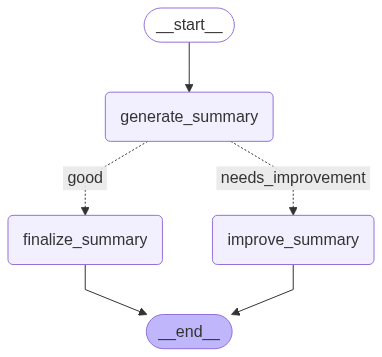

In [9]:
# 워크플로우 구성
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("generate_summary", generate_summary)
workflow.add_node("improve_summary", improve_summary)
workflow.add_node("finalize_summary", finalize_summary)

# 조건부 엣지 추가를 위한 라우팅 설정
workflow.add_conditional_edges(
    "generate_summary",
    check_summary_quality,
    {
        "needs_improvement": "improve_summary",
        "good": "finalize_summary"
    }
)

# 기본 엣지 추가
workflow.add_edge(START, "generate_summary")
workflow.add_edge("improve_summary", END)
workflow.add_edge("finalize_summary", END)

# 그래프 컴파일
graph = workflow.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

`(5) Stream 실행`

- **stream** 방식은 그래프 실행의 **중간 과정**을 실시간으로 확인할 수 있어 투명한 처리가 가능

- 각 노드의 실행 결과가 **순차적으로 스트리밍**되어 처리 흐름을 자세히 모니터링할 수 있음 

- 사용자에게 **진행 상황**을 즉각적으로 보여줄 수 있어 대화형 인터페이스에 적합

- 실시간 피드백이 필요한 복잡한 처리나 사용자 상호작용이 중요한 경우에 이상적인 실행 방식

- **stream_mode**: 스트리밍 실행 시 어떤 정보를 받을지 결정하는 중요한 옵션
   - 단순 진행상황 표시 → "values"
   - 디버깅/개발 → "updates"

In [10]:
# 1. "values" 모드 : 상태 값의 변경사항만 스트리밍
for chunk in graph.stream(initial_state, stream_mode="values"):
    print(chunk)
    print("=" * 100)

{'original_text': '\n인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력, \n자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다. \n최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.\n'}
---- Good Summary ----
{'original_text': '\n인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력, \n자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다. \n최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.\n', 'summary': '인공지능(AI)은 인간의 학습, 추론, 지각, 자연언어 이해 능력을 컴퓨터로 구현한 기술로, 최근 기계학습과 딥러닝의 발전으로 다양한 분야에 활용되고 있다.'}
{'original_text': '\n인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력, \n자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다. \n최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.\n', 'summary': '인공지능(AI)은 인간의 학습, 추론, 지각, 자연언어 이해 능력을 컴퓨터로 구현한 기술로, 최근 기계학습과 딥러닝의 발전으로 다양한 분야에 활용되고 있다.', 'final_summary': '인공지능(AI)은 인간의 학습, 추론, 지각, 자연언어 이해 능력을 컴퓨터로 구현한 기술로, 최근 기계학습과 딥러닝의 발전으로 다양한 분야에 활용되고 있다.'}


In [11]:
# 2. "updates" 모드 : 어떤 노드가 업데이트를 생성했는지 포함 (디버깅용)
for chunk in graph.stream(initial_state, stream_mode="updates"):
    print(chunk)
    print("=" * 100)

---- Good Summary ----
{'generate_summary': {'summary': '인공지능(AI)은 인간의 학습, 추론, 지각, 자연언어 이해 능력을 컴퓨터로 구현한 기술로, 기계학습과 딥러닝의 발전으로 다양한 분야에 활용되고 있다.'}}
{'finalize_summary': {'final_summary': '인공지능(AI)은 인간의 학습, 추론, 지각, 자연언어 이해 능력을 컴퓨터로 구현한 기술로, 기계학습과 딥러닝의 발전으로 다양한 분야에 활용되고 있다.'}}


In [12]:
# 3. "all" 모드 : 각 업데이트의 타입과 내용을 튜플로 반환 (가장 상세)
for chunk_type, chunk_data in graph.stream(initial_state, stream_mode=["values", "updates"]):
    print(f"업데이트 타입: {chunk_type}")
    print(f"데이터: {chunk_data}")
    print("=" * 100)

업데이트 타입: values
데이터: {'original_text': '\n인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력, \n자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다. \n최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.\n'}
---- Good Summary ----
업데이트 타입: updates
데이터: {'generate_summary': {'summary': '인공지능(AI)은 인간의 학습, 추론, 지각, 자연언어 이해 능력을 컴퓨터 프로그램으로 구현한 기술이며, 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.'}}
업데이트 타입: values
데이터: {'original_text': '\n인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력, \n자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다. \n최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.\n', 'summary': '인공지능(AI)은 인간의 학습, 추론, 지각, 자연언어 이해 능력을 컴퓨터 프로그램으로 구현한 기술이며, 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.'}
업데이트 타입: updates
데이터: {'finalize_summary': {'final_summary': '인공지능(AI)은 인간의 학습, 추론, 지각, 자연언어 이해 능력을 컴퓨터 프로그램으로 구현한 기술이며, 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.'}}
업데이트 타입: values
데이터: {'original_text': '\n인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력, \n자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다. \n최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.\n', 'summary': '인공지능(AI)은 인간의 학습, 추론, 지각, 자연언어 이해 능

---

## **Command**

- **Command 객체**는 LangGraph의 핵심 제어 도구로, 노드 함수의 **반환값**으로 사용

- 상태 관리와 흐름 제어를 **동시에 수행**할 수 있어 효율적인 그래프 운영이 가능

- 그래프의 **상태를 동적으로 업데이트**하면서 다음 실행할 노드를 지정할 수 있음 
    1.  **상태 업데이트:** 그래프의 상태(State)를 변경 (예: 새로운 정보를 추가하거나 기존 정보를 수정)
    2.  **제어 흐름:** 다음에 실행할 노드를 지정 가능 

### **StateGraph 수정**

1. `check_summary_quality` 함수를 제거하고 해당 로직을 `generate_summary` 노드에 통합

2. 각 노드가 `Command` 객체를 반환하도록 수정
   - `goto`: 다음에 실행할 노드 지정
   - `update`: 상태 업데이트 내용 지정

3. 조건부 엣지 대신 `Command`를 통한 라우팅을 사용
   - 품질 평가에 따라 `generate_summary`에서 `improve_summary` 또는 `finalize_summary`로 라우팅
   - `improve_summary`와 `finalize_summary`는 모두 END로 라우팅

4. 엣지 설정을 단순화
   - START에서 `generate_summary`로의 엣지만 명시적으로 정의
   - 나머지 라우팅은 `Command`를 통해 처리

In [13]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langchain_openai import ChatOpenAI

# 상태 정의
class State(TypedDict):
    original_text: str   # 원본 텍스트
    summary: str         # 요약본
    final_summary: str   # 최종 요약본

# LLM 인스턴스 생성
summary_llm = ChatOpenAI(model="gpt-4.1-mini")
eval_llm = ChatOpenAI(model="gpt-4.1")

# 요약 생성 노드
def generate_summary(state: State) -> Command[Literal["improve_summary", "finalize_summary"]]:
    """원본 텍스트를 요약하고 품질을 평가하는 노드"""
    # 요약 생성
    summary_prompt = f"""다음 텍스트를 핵심 내용 중심으로 간단히 요약해주세요:

    [텍스트]
    {state['original_text']}

    [요약]
    """
    summary = summary_llm.invoke(summary_prompt).content

#     summary = """인공지능은 컴퓨터 과학의 한 분야이며 인간의 능력을 구현한 것인데 \
# 요즘에는 정말 다양한 분야에서 활용되고 있고 특히 기계학습이랑 딥러닝이 발전하면서 \
# 더욱 활용도가 높아지고 있다고 합니다"""  # 테스트용

    # 품질 평가
    eval_prompt = f"""다음 요약의 품질을 평가해주세요. 
    요약이 명확하고 핵심을 잘 전달하면 'good'을, 
    개선이 필요하면 'needs_improvement'를 응답해주세요.
    
    요약본: {summary}
    """
    quality = eval_llm.invoke(eval_prompt).content.lower().strip()
    
    # 상태 업데이트와 함께 다음 노드로 라우팅
    return Command(
        goto="finalize_summary" if "good" in quality else "improve_summary",
        update={"summary": summary}
    )

# 요약 개선 노드
def improve_summary(state: State) -> Command[Literal[END]]:
    """요약을 개선하고 다듬는 노드"""
    prompt = f"""다음 요약을 더 명확하고 간결하게 개선해주세요:
    
    [기존 요약]
    {state['summary']}

    [개선 요약]
    """
    improved_summary = llm.invoke(prompt).content
    
    # 상태 업데이트와 함께 다음 노드로 라우팅
    return Command(
        goto=END,
        update={"final_summary": improved_summary}
    )

# 최종 요약 설정 노드
def finalize_summary(state: State) -> Command[Literal[END]]:
    """현재 요약을 최종 요약으로 설정하는 노드"""

    # 상태 업데이트와 함께 다음 노드로 라우팅
    return Command(
        goto=END,
        update={"final_summary": state["summary"]}
    )


**`Command` vs. 조건부 엣지(Conditional Edges)**

- **Command**는 상태 업데이트와 노드 이동을 **동시에 처리**할 때 사용되며, 특히 정보 전달이 필요한 복잡한 전환에 적합

- **조건부 엣지**는 단순한 분기 처리에 사용되며, 상태 변경 없이 **조건에 따른 이동**만 수행

- 두 방식의 **선택 기준**은 상태 업데이트 필요 여부에 따라 결정

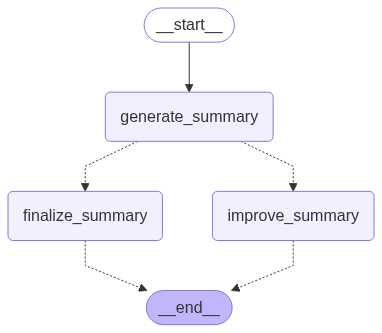

In [14]:
# 워크플로우 구성
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("generate_summary", generate_summary)
workflow.add_node("improve_summary", improve_summary)
workflow.add_node("finalize_summary", finalize_summary)

# 기본 엣지 추가
workflow.add_edge(START, "generate_summary")

# 그래프 컴파일
graph = workflow.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
# 그래프 실행 및 결과 확인
text = """
인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력,
자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다.
최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.
"""

initial_state = {
    "original_text": text,
}

for chunk in graph.stream(initial_state, stream_mode="values"):
    pprint(chunk)
    print("=" * 100)

{'original_text': '\n'
                  '인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력,\n'
                  '자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다.\n'
                  '최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.\n'}
{'original_text': '\n'
                  '인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력,\n'
                  '자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다.\n'
                  '최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.\n',
 'summary': '[요약]\n'
            '\n'
            '인공지능은 인간의 학습, 추론, 지각, 자연언어 이해 능력을 컴퓨터로 구현한 기술로, 최근 기계학습과 딥러닝의 '
            '발전으로 다양한 분야에 활용되고 있다.'}
{'final_summary': '[요약]\n'
                  '\n'
                  '인공지능은 인간의 학습, 추론, 지각, 자연언어 이해 능력을 컴퓨터로 구현한 기술로, 최근 기계학습과 '
                  '딥러닝의 발전으로 다양한 분야에 활용되고 있다.',
 'original_text': '\n'
                  '인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력,\n'
                  '자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다.\n'
                  '최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.\n',
 'summary': '[요약]\n'
            '\n'
 